In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 기존 코드에서 수정사항
- experiment_name에서 시간 삭제
- 기존에 데이터셋 불러오는 lib.Dataset 함수를 사용하지 않음
- as_tensor 함수 사용할 때 dtype=torch.float32 지정 --> trainer.py의 118, 119 line도 수정함
- 타겟변수의 초기화값을 normal 분포 대신 np.min(train_y) np.max(train_y) 사이의 값을 갖도록 하기 위해 수정 --> odst.py의 ODST 클래스에 ir(어떤 분포 사용할건지), ir_min(uniform일 때 최소값), ir_max(uniform일 때 최대값) 인자 추가하고, ir=='uniform'일 경우 U(np.min(train_y) np.max(train_y)) 를 따르는 값으로 초기화되도록 변경

In [19]:
#!pip install tensorboardX
#!pip install qhoptim
#!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.2 MB/s 


In [14]:
% cd /content/drive/MyDrive/Lab/node-master

/content/drive/MyDrive/Lab/node-master


In [20]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import libs
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 데이터 load & 전처리

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Lab/housing.csv')

# median house value가 500000보다 큰 데이터는 모두 500001로 기록됨 -> 분석에서 제외
data = data[data['median_house_value'] != 500001]

# 모델링 시 < 로 인한 에러 방지
data.loc[data['ocean_proximity']=='<1H OCEAN', 'ocean_proximity'] = '1H OCEAN'

# na 처리
data = data.dropna(axis=0)   # na 값이 포함된 행은 제거

# 범주형 변수를 수치형으로 변환: one hot encoding
data = pd.get_dummies(data)

print(data.shape)
data.head()

X = data.drop('median_house_value', axis=1)
y = data['median_house_value']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=777)
train_x.head()

(19475, 14)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
4748,-118.35,34.05,52.0,1971.0,414.0,1065.0,409.0,3.6435,1,0,0,0,0
15001,-117.02,32.74,12.0,3301.0,963.0,2000.0,879.0,1.8594,0,0,0,0,1
5634,-118.28,33.74,40.0,1751.0,512.0,1939.0,503.0,1.5394,0,0,0,0,1
9084,-118.19,34.67,8.0,11275.0,1822.0,5731.0,1692.0,5.0285,0,1,0,0,0
10781,-117.90,33.64,36.0,2017.0,357.0,850.0,348.0,5.0532,1,0,0,0,0


In [5]:
def getpr2(testy, predy):
    result = 1 - sum((testy - predy)**2) / sum((testy - np.mean(testy))**2)
    return result

### Modeling

In [8]:
from qhoptim.pyt import QHAdam
from tqdm import tqdm

In [9]:
train_x, train_y = train_x.values, train_y.values
test_x, test_y = test_x.values, test_y.values

# validation set 생성
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=777)

#### case 1

In [ ]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=3, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, ir_min=np.min(train_y), ir_max=np.max(train_y)),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0726-1'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history1, mse_history1 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0726-1


In [ ]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=300)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history1.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history1.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

0it [00:00, ?it/s]C:\Users\YJ-HWANG\anaconda3\lib\site-packages\qhoptim\pyt\qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)
49it [01:56,  2.55s/it]

Saved logs/California 0726-1\checkpoint_temp_50.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


50it [02:00,  3.04s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_50.pth
iteration:50 loss:8733168640.0 mse:9407767873.78802


99it [03:58,  2.60s/it]

Saved logs/California 0726-1\checkpoint_temp_100.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


100it [04:02,  3.07s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_100.pth
iteration:100 loss:8819767296.0 mse:9328443722.728811


149it [06:02,  2.53s/it]

Saved logs/California 0726-1\checkpoint_temp_150.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


150it [06:06,  3.02s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_150.pth
iteration:150 loss:8526539776.0 mse:9153641237.384441


199it [08:11,  2.58s/it]

Saved logs/California 0726-1\checkpoint_temp_200.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


200it [08:15,  3.18s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_200.pth
iteration:200 loss:8591839232.0 mse:8952485780.023819


249it [10:21,  2.46s/it]

Saved logs/California 0726-1\checkpoint_temp_250.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


250it [10:26,  3.09s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_250.pth
iteration:250 loss:8784103424.0 mse:8805680271.794367


299it [12:33,  2.03s/it]

Saved logs/California 0726-1\checkpoint_temp_300.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


300it [12:37,  2.79s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_300.pth
iteration:300 loss:8500045824.0 mse:8453071686.507381


349it [14:44,  2.66s/it]

Saved logs/California 0726-1\checkpoint_temp_350.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


350it [14:48,  3.23s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_350.pth
iteration:350 loss:7778243072.0 mse:8279562016.599421


399it [16:55,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_400.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


400it [17:00,  3.26s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_400.pth
iteration:400 loss:7750032384.0 mse:8176896590.253435


449it [19:07,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_450.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


450it [19:11,  3.25s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_450.pth
iteration:450 loss:8770159616.0 mse:8058121051.735008


499it [21:19,  2.68s/it]

Saved logs/California 0726-1\checkpoint_temp_500.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


500it [21:24,  3.25s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_500.pth
iteration:500 loss:8046742528.0 mse:8017888024.0382805


549it [23:34,  2.91s/it]

Saved logs/California 0726-1\checkpoint_temp_550.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


550it [23:38,  3.50s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_550.pth
iteration:550 loss:7175115776.0 mse:7953894755.458345


599it [25:52,  2.47s/it]

Saved logs/California 0726-1\checkpoint_temp_600.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


600it [25:58,  3.43s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_600.pth
iteration:600 loss:7404773376.0 mse:7922423504.840823


649it [28:14,  3.06s/it]

Saved logs/California 0726-1\checkpoint_temp_650.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


650it [28:17,  2.89s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_650.pth
iteration:650 loss:7007269376.0 mse:7879656288.750303


699it [30:34,  2.84s/it]

Saved logs/California 0726-1\checkpoint_temp_700.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


700it [30:38,  3.40s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_700.pth
iteration:700 loss:7842414592.0 mse:7858505522.867157


749it [32:50,  2.69s/it]

Saved logs/California 0726-1\checkpoint_temp_750.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


750it [32:54,  3.20s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_750.pth
iteration:750 loss:7406386176.0 mse:7848673245.555089


799it [35:07,  2.86s/it]

Saved logs/California 0726-1\checkpoint_temp_800.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


800it [35:12,  3.41s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_800.pth
iteration:800 loss:8319941120.0 mse:7813826201.361095


849it [37:29,  2.90s/it]

Saved logs/California 0726-1\checkpoint_temp_850.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


850it [37:34,  3.44s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_850.pth
iteration:850 loss:7746624512.0 mse:7780908620.113374


899it [39:50,  2.59s/it]

Saved logs/California 0726-1\checkpoint_temp_900.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


900it [39:55,  3.22s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_900.pth
iteration:900 loss:7460999168.0 mse:7743065377.20652


949it [42:11,  2.25s/it]

Saved logs/California 0726-1\checkpoint_temp_950.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


950it [42:16,  2.99s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_950.pth
iteration:950 loss:8009326592.0 mse:7705040321.855157


999it [44:34,  2.92s/it]

Saved logs/California 0726-1\checkpoint_temp_1000.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1000it [44:39,  3.44s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1000.pth
iteration:1000 loss:7318208512.0 mse:7674685087.618638


1049it [46:55,  2.90s/it]

Saved logs/California 0726-1\checkpoint_temp_1050.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1050it [47:00,  3.44s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1050.pth
iteration:1050 loss:7702496768.0 mse:7616026109.151439


1099it [49:14,  2.76s/it]

Saved logs/California 0726-1\checkpoint_temp_1100.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1100it [49:19,  3.39s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1100.pth
iteration:1100 loss:7831135232.0 mse:7556782537.5036


1149it [51:31,  2.64s/it]

Saved logs/California 0726-1\checkpoint_temp_1150.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1150it [51:35,  3.16s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1150.pth
iteration:1150 loss:7976542208.0 mse:7500069638.210361


1199it [53:48,  2.79s/it]

Saved logs/California 0726-1\checkpoint_temp_1200.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1200it [53:52,  3.34s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1200.pth
iteration:1200 loss:7400169472.0 mse:7474390255.523247


1249it [56:04,  2.36s/it]

Saved logs/California 0726-1\checkpoint_temp_1250.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1250it [56:08,  3.03s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1250.pth
iteration:1250 loss:7244167168.0 mse:7423833830.062457


1299it [58:22,  2.79s/it]

Saved logs/California 0726-1\checkpoint_temp_1300.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1300it [58:24,  2.64s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1300.pth
iteration:1300 loss:7158482944.0 mse:7384308621.29796


1349it [1:00:37,  2.79s/it]

Saved logs/California 0726-1\checkpoint_temp_1350.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1350it [1:00:41,  3.29s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1350.pth
iteration:1350 loss:7361700352.0 mse:7347826090.8136015


1399it [1:02:51,  2.73s/it]

Saved logs/California 0726-1\checkpoint_temp_1400.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1400it [1:02:55,  3.23s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1400.pth
iteration:1400 loss:7820849152.0 mse:7313260844.747322


1449it [1:05:06,  2.66s/it]

Saved logs/California 0726-1\checkpoint_temp_1450.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1450it [1:05:10,  3.17s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1450.pth
iteration:1450 loss:6993173504.0 mse:7282926815.091392


1499it [1:07:16,  2.56s/it]

Saved logs/California 0726-1\checkpoint_temp_1500.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1500it [1:07:21,  3.09s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1500.pth
iteration:1500 loss:7441461760.0 mse:7277502864.270716


1549it [1:09:29,  2.43s/it]

Saved logs/California 0726-1\checkpoint_temp_1550.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1550it [1:09:34,  3.05s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1550.pth
iteration:1550 loss:6828965888.0 mse:7245564059.777821


1599it [1:11:42,  2.08s/it]

Saved logs/California 0726-1\checkpoint_temp_1600.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1600it [1:11:46,  2.76s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1600.pth
iteration:1600 loss:7158150144.0 mse:7209018232.00081


1649it [1:13:58,  2.92s/it]

Saved logs/California 0726-1\checkpoint_temp_1650.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1650it [1:14:02,  3.38s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1650.pth
iteration:1650 loss:6553931264.0 mse:7192379710.798972


1699it [1:16:15,  3.01s/it]

Saved logs/California 0726-1\checkpoint_temp_1700.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1700it [1:16:19,  3.47s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1700.pth
iteration:1700 loss:7606986752.0 mse:7178620446.582087


1749it [1:18:36,  2.76s/it]

Saved logs/California 0726-1\checkpoint_temp_1750.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1750it [1:18:40,  3.26s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1750.pth
iteration:1750 loss:7619272192.0 mse:7160745628.58333


1799it [1:20:50,  2.79s/it]

Saved logs/California 0726-1\checkpoint_temp_1800.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1800it [1:20:55,  3.35s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1800.pth
iteration:1800 loss:7413635072.0 mse:7148481602.054864


1849it [1:23:05,  2.52s/it]

Saved logs/California 0726-1\checkpoint_temp_1850.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1850it [1:23:10,  3.08s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1850.pth
iteration:1850 loss:7647560704.0 mse:7146784062.3543215


1899it [1:25:20,  2.42s/it]

Saved logs/California 0726-1\checkpoint_temp_1900.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1900it [1:25:25,  3.16s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1900.pth
iteration:1900 loss:7001547264.0 mse:7135180514.824399


1949it [1:27:39,  2.77s/it]

Saved logs/California 0726-1\checkpoint_temp_1950.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


1950it [1:27:41,  2.61s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_1950.pth
iteration:1950 loss:7429931008.0 mse:7106218569.996282


1999it [1:29:54,  2.82s/it]

Saved logs/California 0726-1\checkpoint_temp_2000.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2000it [1:29:59,  3.30s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2000.pth
iteration:2000 loss:6985226240.0 mse:7091002889.243474


2049it [1:32:11,  2.81s/it]

Saved logs/California 0726-1\checkpoint_temp_2050.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2050it [1:32:16,  3.30s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2050.pth
iteration:2050 loss:7133703680.0 mse:7080317416.8879595


2099it [1:34:29,  2.74s/it]

Saved logs/California 0726-1\checkpoint_temp_2100.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2100it [1:34:34,  3.24s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2100.pth
iteration:2100 loss:7581015040.0 mse:7061195835.788639


2149it [1:36:48,  2.61s/it]

Saved logs/California 0726-1\checkpoint_temp_2150.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2150it [1:36:53,  3.27s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2150.pth
iteration:2150 loss:6920626176.0 mse:7042310291.837788


2199it [1:39:07,  2.50s/it]

Saved logs/California 0726-1\checkpoint_temp_2200.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2200it [1:39:11,  3.08s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2200.pth
iteration:2200 loss:6501355520.0 mse:7030849288.71527


2249it [1:41:17,  2.04s/it]

Saved logs/California 0726-1\checkpoint_temp_2250.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2250it [1:41:22,  2.72s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2250.pth
iteration:2250 loss:7464953856.0 mse:7012142179.1890955


2299it [1:43:33,  2.76s/it]

Saved logs/California 0726-1\checkpoint_temp_2300.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2300it [1:43:37,  3.24s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2300.pth
iteration:2300 loss:6645966848.0 mse:6998155574.368549


2349it [1:45:44,  2.71s/it]

Saved logs/California 0726-1\checkpoint_temp_2350.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2350it [1:45:48,  3.21s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2350.pth
iteration:2350 loss:7303289344.0 mse:6984877369.799764


2399it [1:48:01,  2.80s/it]

Saved logs/California 0726-1\checkpoint_temp_2400.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2400it [1:48:05,  3.25s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2400.pth
iteration:2400 loss:6613739520.0 mse:6974837498.159181


2449it [1:50:17,  2.56s/it]

Saved logs/California 0726-1\checkpoint_temp_2450.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2450it [1:50:21,  3.12s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2450.pth
iteration:2450 loss:6761422848.0 mse:6962509468.664073


2499it [1:52:32,  2.58s/it]

Saved logs/California 0726-1\checkpoint_temp_2500.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2500it [1:52:37,  3.16s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2500.pth
iteration:2500 loss:7290284032.0 mse:6952243732.184334


2549it [1:54:46,  2.34s/it]

Saved logs/California 0726-1\checkpoint_temp_2550.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2550it [1:54:50,  2.96s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2550.pth
iteration:2550 loss:6951099392.0 mse:6941849368.979217


2599it [1:57:00,  2.68s/it]

Saved logs/California 0726-1\checkpoint_temp_2600.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2600it [1:57:02,  2.53s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2600.pth
iteration:2600 loss:7165286400.0 mse:6930171418.965218


2649it [1:59:11,  2.76s/it]

Saved logs/California 0726-1\checkpoint_temp_2650.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2650it [1:59:15,  3.27s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2650.pth
iteration:2650 loss:6911412224.0 mse:6915373362.000595


2699it [2:01:24,  2.71s/it]

Saved logs/California 0726-1\checkpoint_temp_2700.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2700it [2:01:28,  3.24s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2700.pth
iteration:2700 loss:6558871552.0 mse:6895311964.878465


2749it [2:03:37,  2.65s/it]

Saved logs/California 0726-1\checkpoint_temp_2750.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2750it [2:03:41,  3.15s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2750.pth
iteration:2750 loss:6311019520.0 mse:6883703398.681144


2799it [2:05:50,  2.57s/it]

Saved logs/California 0726-1\checkpoint_temp_2800.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2800it [2:05:55,  3.13s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2800.pth
iteration:2800 loss:6942216192.0 mse:6876490953.371969


2849it [2:08:11,  2.63s/it]

Saved logs/California 0726-1\checkpoint_temp_2850.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2850it [2:08:16,  3.26s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2850.pth
iteration:2850 loss:7057166336.0 mse:6863446857.086015


2899it [2:10:25,  2.06s/it]

Saved logs/California 0726-1\checkpoint_temp_2900.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2900it [2:10:30,  2.74s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2900.pth
iteration:2900 loss:6783133696.0 mse:6853953325.495213


2949it [2:12:37,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_2950.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


2950it [2:12:42,  3.17s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_2950.pth
iteration:2950 loss:6591455744.0 mse:6845230500.8454075


2999it [2:14:47,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_3000.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3000it [2:14:52,  3.16s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3000.pth
iteration:3000 loss:6963409408.0 mse:6833179384.622952


3049it [2:16:58,  2.63s/it]

Saved logs/California 0726-1\checkpoint_temp_3050.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3050it [2:17:02,  3.18s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3050.pth
iteration:3050 loss:6797450240.0 mse:6824344032.019488


3099it [2:19:09,  2.74s/it]

Saved logs/California 0726-1\checkpoint_temp_3100.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3100it [2:19:14,  3.26s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3100.pth
iteration:3100 loss:6700349952.0 mse:6819940854.292119


3149it [2:21:24,  2.54s/it]

Saved logs/California 0726-1\checkpoint_temp_3150.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3150it [2:21:28,  3.09s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3150.pth
iteration:3150 loss:7048649216.0 mse:6814524874.878814


3199it [2:23:38,  2.31s/it]

Saved logs/California 0726-1\checkpoint_temp_3200.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3200it [2:23:43,  2.97s/it]

Loaded logs/California 0726-1\checkpoint_temp_3200.pth
iteration:3200 loss:6602021376.0 mse:6821816915.48736


3249it [2:25:56,  2.94s/it]

Saved logs/California 0726-1\checkpoint_temp_3250.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3250it [2:25:58,  2.77s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3250.pth
iteration:3250 loss:7473165312.0 mse:6804664383.386972


3299it [2:28:13,  2.95s/it]

Saved logs/California 0726-1\checkpoint_temp_3300.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3300it [2:28:18,  3.49s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3300.pth
iteration:3300 loss:6727342592.0 mse:6802996180.943596


3349it [2:30:31,  2.78s/it]

Saved logs/California 0726-1\checkpoint_temp_3350.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3350it [2:30:35,  3.22s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3350.pth
iteration:3350 loss:6850525696.0 mse:6798476118.964122


3399it [2:32:44,  2.66s/it]

Saved logs/California 0726-1\checkpoint_temp_3400.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3400it [2:32:48,  3.15s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3400.pth
iteration:3400 loss:7077766144.0 mse:6790969990.402337


3449it [2:35:03,  2.74s/it]

Saved logs/California 0726-1\checkpoint_temp_3450.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3450it [2:35:08,  3.26s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3450.pth
iteration:3450 loss:6796398080.0 mse:6784042154.605781


3499it [2:37:16,  2.37s/it]

Saved logs/California 0726-1\checkpoint_temp_3500.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3500it [2:37:20,  2.95s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3500.pth
iteration:3500 loss:6699418112.0 mse:6776345146.177253


3549it [2:39:27,  2.23s/it]

Saved logs/California 0726-1\checkpoint_temp_3550.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3550it [2:39:32,  2.93s/it]

Loaded logs/California 0726-1\checkpoint_temp_3550.pth
iteration:3550 loss:7201631744.0 mse:6780943796.717853


3599it [2:41:46,  2.76s/it]

Saved logs/California 0726-1\checkpoint_temp_3600.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3600it [2:41:50,  3.29s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3600.pth
iteration:3600 loss:6862806528.0 mse:6768365738.419846


3649it [2:43:59,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_3650.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3650it [2:44:03,  3.15s/it]

Loaded logs/California 0726-1\checkpoint_temp_3650.pth
iteration:3650 loss:6567183360.0 mse:6770155942.472731


3699it [2:46:14,  2.95s/it]

Saved logs/California 0726-1\checkpoint_temp_3700.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3700it [2:46:18,  3.38s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3700.pth
iteration:3700 loss:6527838208.0 mse:6764270348.959721


3749it [2:48:34,  2.67s/it]

Saved logs/California 0726-1\checkpoint_temp_3750.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3750it [2:48:39,  3.18s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3750.pth
iteration:3750 loss:6512738304.0 mse:6760913455.997221


3799it [2:50:47,  2.58s/it]

Saved logs/California 0726-1\checkpoint_temp_3800.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3800it [2:50:52,  3.21s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3800.pth
iteration:3800 loss:6460982272.0 mse:6749453322.05822


3849it [2:53:03,  2.24s/it]

Saved logs/California 0726-1\checkpoint_temp_3850.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3850it [2:53:07,  2.87s/it]

Saved logs/California 0726-1\checkpoint_best_mse.pth
Loaded logs/California 0726-1\checkpoint_temp_3850.pth
iteration:3850 loss:6640676864.0 mse:6744615537.977756


3899it [2:55:18,  2.82s/it]

Saved logs/California 0726-1\checkpoint_temp_3900.pth
Loaded logs/California 0726-1\checkpoint_avg.pth


3900it [2:55:21,  2.70s/it]

Loaded logs/California 0726-1\checkpoint_temp_3900.pth
iteration:3900 loss:7522515456.0 mse:6748916663.132182


In [ ]:
y_pred1 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred1))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred1)))

RMSE: 84865.84977517142
Pseudo R^2: 0.26246465992828694


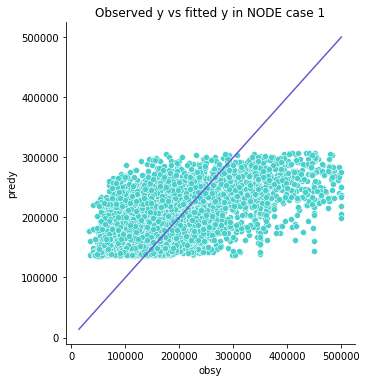

In [ ]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred1})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 1");

In [ ]:
np.max(train_y)

500000.0

In [ ]:
np.min(train_y)

14999.0

In [ ]:
print(np.min(y_pred1))
print(np.max(y_pred1))

136040.61
307556.78


#### case 2

In [ ]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 64, num_layers=8, tree_dim=3, depth=4, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, ir_min=np.min(train_y), ir_max=np.max(train_y)),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0726-3'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history2, mse_history2 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0726-3


In [ ]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=200)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history2.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history2.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

26it [00:26,  1.19it/s]

Saved logs/California 0726-3\checkpoint_temp_50.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


27it [00:28,  1.32s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_50.pth
iteration:50 loss:9746423808.0 mse:9552586120.888855


76it [01:19,  1.01s/it]

Saved logs/California 0726-3\checkpoint_temp_100.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


77it [01:21,  1.43s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_100.pth
iteration:100 loss:8361310720.0 mse:9087682673.795666


126it [02:13,  1.04s/it]

Saved logs/California 0726-3\checkpoint_temp_150.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


127it [02:15,  1.49s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_150.pth
iteration:150 loss:8145636352.0 mse:8989621646.193169


176it [03:07,  1.05s/it]

Saved logs/California 0726-3\checkpoint_temp_200.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


177it [03:10,  1.58s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_200.pth
iteration:200 loss:7923324928.0 mse:8756534542.78166


226it [04:01,  1.04s/it]

Saved logs/California 0726-3\checkpoint_temp_250.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


227it [04:04,  1.54s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_250.pth
iteration:250 loss:7614365184.0 mse:8482464014.496621


276it [04:56,  1.02it/s]

Saved logs/California 0726-3\checkpoint_temp_300.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


277it [04:59,  1.48s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_300.pth
iteration:300 loss:7760529920.0 mse:8033070084.380971


326it [05:50,  1.15it/s]

Saved logs/California 0726-3\checkpoint_temp_350.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


327it [05:52,  1.33s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_350.pth
iteration:350 loss:8941047808.0 mse:7905628479.375953


376it [06:43,  1.06s/it]

Saved logs/California 0726-3\checkpoint_temp_400.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


377it [06:45,  1.29s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_400.pth
iteration:400 loss:8219195392.0 mse:7812164866.630745


426it [07:38,  1.15s/it]

Saved logs/California 0726-3\checkpoint_temp_450.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


427it [07:40,  1.58s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_450.pth
iteration:450 loss:7431672320.0 mse:7792882434.819033


476it [08:34,  1.09s/it]

Saved logs/California 0726-3\checkpoint_temp_500.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


477it [08:36,  1.50s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_500.pth
iteration:500 loss:7567659520.0 mse:7719607380.626172


526it [09:28,  1.02s/it]

Saved logs/California 0726-3\checkpoint_temp_550.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


527it [09:30,  1.45s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_550.pth
iteration:550 loss:7389562368.0 mse:7651114637.461755


576it [10:22,  1.01it/s]

Saved logs/California 0726-3\checkpoint_temp_600.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


577it [10:25,  1.47s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_600.pth
iteration:600 loss:7016882176.0 mse:7554077085.131278


626it [11:17,  1.04it/s]

Saved logs/California 0726-3\checkpoint_temp_650.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


627it [11:19,  1.41s/it]

Loaded logs/California 0726-3\checkpoint_temp_650.pth
iteration:650 loss:7897270272.0 mse:7596829770.026057


676it [12:12,  1.21it/s]

Saved logs/California 0726-3\checkpoint_temp_700.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


677it [12:15,  1.32s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_700.pth
iteration:700 loss:8391674368.0 mse:7469549760.089347


726it [13:06,  1.03s/it]

Saved logs/California 0726-3\checkpoint_temp_750.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


727it [13:09,  1.48s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_750.pth
iteration:750 loss:7682625536.0 mse:7335673153.272982


776it [13:59,  1.02s/it]

Saved logs/California 0726-3\checkpoint_temp_800.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


777it [14:01,  1.45s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_800.pth
iteration:800 loss:7461600256.0 mse:7244358142.184833


826it [14:51,  1.01s/it]

Saved logs/California 0726-3\checkpoint_temp_850.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


827it [14:54,  1.45s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_850.pth
iteration:850 loss:7282143744.0 mse:7172147880.22408


876it [15:43,  1.01it/s]

Saved logs/California 0726-3\checkpoint_temp_900.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


877it [15:46,  1.42s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_900.pth
iteration:900 loss:7246161920.0 mse:7074595166.062926


926it [16:36,  1.04it/s]

Saved logs/California 0726-3\checkpoint_temp_950.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


927it [16:39,  1.41s/it]

Loaded logs/California 0726-3\checkpoint_temp_950.pth
iteration:950 loss:7264417792.0 mse:7079156663.865758


976it [17:29,  1.12it/s]

Saved logs/California 0726-3\checkpoint_temp_1000.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


977it [17:31,  1.37s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1000.pth
iteration:1000 loss:7670363136.0 mse:7049947369.402993


1026it [18:22,  1.07s/it]

Saved logs/California 0726-3\checkpoint_temp_1050.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1027it [18:24,  1.30s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1050.pth
iteration:1050 loss:7373251072.0 mse:6947986179.306572


1076it [19:15,  1.03s/it]

Saved logs/California 0726-3\checkpoint_temp_1100.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1077it [19:17,  1.47s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1100.pth
iteration:1100 loss:7179184128.0 mse:6880427521.969847


1126it [20:08,  1.04s/it]

Saved logs/California 0726-3\checkpoint_temp_1150.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1127it [20:10,  1.46s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1150.pth
iteration:1150 loss:7352072704.0 mse:6841870086.2520275


1176it [21:00,  1.02s/it]

Saved logs/California 0726-3\checkpoint_temp_1200.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1177it [21:03,  1.45s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1200.pth
iteration:1200 loss:7094424576.0 mse:6830700968.603766


1226it [21:53,  1.01s/it]

Saved logs/California 0726-3\checkpoint_temp_1250.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1227it [21:56,  1.49s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1250.pth
iteration:1250 loss:6577082880.0 mse:6812397736.711982


1276it [22:47,  1.00it/s]

Saved logs/California 0726-3\checkpoint_temp_1300.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1277it [22:50,  1.51s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1300.pth
iteration:1300 loss:6683864064.0 mse:6762967105.175537


1326it [23:41,  1.20it/s]

Saved logs/California 0726-3\checkpoint_temp_1350.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1327it [23:44,  1.33s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1350.pth
iteration:1350 loss:6873003520.0 mse:6718873693.945072


1376it [24:35,  1.04s/it]

Saved logs/California 0726-3\checkpoint_temp_1400.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1377it [24:37,  1.47s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1400.pth
iteration:1400 loss:6506468352.0 mse:6718621204.005763


1426it [25:27,  1.03s/it]

Saved logs/California 0726-3\checkpoint_temp_1450.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1427it [25:30,  1.47s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1450.pth
iteration:1450 loss:7418951680.0 mse:6687947251.086659


1476it [26:20,  1.01s/it]

Saved logs/California 0726-3\checkpoint_temp_1500.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1477it [26:22,  1.46s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1500.pth
iteration:1500 loss:6269421568.0 mse:6674847277.705458


1526it [27:13,  1.02s/it]

Saved logs/California 0726-3\checkpoint_temp_1550.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1527it [27:15,  1.47s/it]

Saved logs/California 0726-3\checkpoint_best_mse.pth
Loaded logs/California 0726-3\checkpoint_temp_1550.pth
iteration:1550 loss:6099338752.0 mse:6661957009.988181


1576it [28:06,  1.03it/s]

Saved logs/California 0726-3\checkpoint_temp_1600.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1577it [28:08,  1.42s/it]

Loaded logs/California 0726-3\checkpoint_temp_1600.pth
iteration:1600 loss:7308204032.0 mse:6764974128.967339


1626it [28:59,  1.09it/s]

Saved logs/California 0726-3\checkpoint_temp_1650.pth
Loaded logs/California 0726-3\checkpoint_avg.pth


1627it [29:02,  1.41s/it]

Loaded logs/California 0726-3\checkpoint_temp_1650.pth
iteration:1650 loss:6823493632.0 mse:6747174192.63638


1627it [29:03,  1.07s/it]

BREAK. There is no improvment for 100 steps
Best step:  1550
Best Val MSE: 6661957009.98818


In [ ]:
y_pred2 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred2))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred2)))

RMSE: 82831.37034438268
Pseudo R^2: 0.2974025016758789


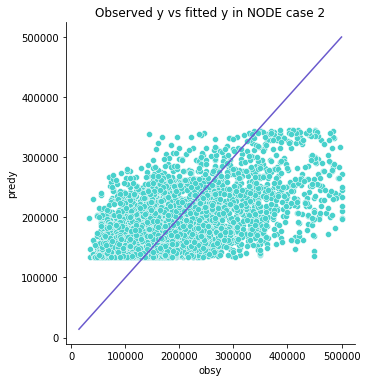

In [ ]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred2})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 2");

#### case3

In [ ]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 64, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, ir_min=np.min(train_y), ir_max=np.max(train_y)),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0726-4'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history3, mse_history3 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0726-4


In [ ]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=200)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history3.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history3.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

49it [02:52,  3.67s/it]

Saved logs/California 0726-4\checkpoint_temp_50.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


50it [02:58,  4.54s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_50.pth
iteration:50 loss:9629693952.0 mse:9515567222.794971


99it [05:49,  3.75s/it]

Saved logs/California 0726-4\checkpoint_temp_100.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


100it [05:56,  4.67s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_100.pth
iteration:100 loss:9500817408.0 mse:8836819521.936424


149it [08:47,  3.59s/it]

Saved logs/California 0726-4\checkpoint_temp_150.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


150it [08:54,  4.66s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_150.pth
iteration:150 loss:9423744000.0 mse:8576645747.383219


199it [11:47,  3.43s/it]

Saved logs/California 0726-4\checkpoint_temp_200.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


200it [11:54,  4.38s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_200.pth
iteration:200 loss:8345089024.0 mse:8412775436.326083


249it [14:47,  3.19s/it]

Saved logs/California 0726-4\checkpoint_temp_250.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


250it [14:53,  4.18s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_250.pth
iteration:250 loss:8138242048.0 mse:8287713806.8227005


299it [17:45,  2.87s/it]

Saved logs/California 0726-4\checkpoint_temp_300.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


300it [17:52,  4.03s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_300.pth
iteration:300 loss:7849933824.0 mse:8006397442.757947


349it [20:48,  3.85s/it]

Saved logs/California 0726-4\checkpoint_temp_350.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


350it [20:55,  4.85s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_350.pth
iteration:350 loss:7512340480.0 mse:7874707170.931528


399it [23:51,  3.94s/it]

Saved logs/California 0726-4\checkpoint_temp_400.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


400it [23:58,  4.85s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_400.pth
iteration:400 loss:7758489600.0 mse:7767452967.324895


449it [26:55,  3.68s/it]

Saved logs/California 0726-4\checkpoint_temp_450.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


450it [27:02,  4.71s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_450.pth
iteration:450 loss:7594212352.0 mse:7630616333.943339


499it [30:01,  3.61s/it]

Saved logs/California 0726-4\checkpoint_temp_500.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


500it [30:08,  4.53s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_500.pth
iteration:500 loss:7707666944.0 mse:7488513159.76926


549it [33:08,  3.68s/it]

Saved logs/California 0726-4\checkpoint_temp_550.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


550it [33:15,  4.59s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_550.pth
iteration:550 loss:8208094720.0 mse:7426394155.446571


599it [36:09,  3.14s/it]

Saved logs/California 0726-4\checkpoint_temp_600.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


600it [36:16,  4.16s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_600.pth
iteration:600 loss:7690365952.0 mse:7322038740.778643


649it [39:11,  3.70s/it]

Saved logs/California 0726-4\checkpoint_temp_650.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


650it [39:15,  3.75s/it]

Loaded logs/California 0726-4\checkpoint_temp_650.pth
iteration:650 loss:9395286016.0 mse:7342345593.170356


699it [42:10,  3.70s/it]

Saved logs/California 0726-4\checkpoint_temp_700.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


700it [42:17,  4.61s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_700.pth
iteration:700 loss:7097525760.0 mse:7257519008.98661


749it [45:09,  3.59s/it]

Saved logs/California 0726-4\checkpoint_temp_750.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


750it [45:15,  4.52s/it]

Loaded logs/California 0726-4\checkpoint_temp_750.pth
iteration:750 loss:7903981568.0 mse:7355216425.411485


799it [48:08,  3.58s/it]

Saved logs/California 0726-4\checkpoint_temp_800.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


800it [48:14,  4.47s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_800.pth
iteration:800 loss:7332727808.0 mse:7081899105.8394375


849it [51:07,  3.55s/it]

Saved logs/California 0726-4\checkpoint_temp_850.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


850it [51:14,  4.54s/it]

Loaded logs/California 0726-4\checkpoint_temp_850.pth
iteration:850 loss:6625299456.0 mse:7090960032.948058


899it [54:07,  3.32s/it]

Saved logs/California 0726-4\checkpoint_temp_900.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


900it [54:13,  4.36s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_900.pth
iteration:900 loss:7312416256.0 mse:6934940533.825073


949it [57:06,  2.86s/it]

Saved logs/California 0726-4\checkpoint_temp_950.pth


950it [57:12,  4.05s/it]

Loaded logs/California 0726-4\checkpoint_avg.pth
Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_950.pth
iteration:950 loss:7889907712.0 mse:6914878828.002595


999it [1:00:09,  3.70s/it]

Saved logs/California 0726-4\checkpoint_temp_1000.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1000it [1:00:15,  4.53s/it]

Loaded logs/California 0726-4\checkpoint_temp_1000.pth
iteration:1000 loss:6854083072.0 mse:6934330616.048648


1049it [1:03:07,  3.73s/it]

Saved logs/California 0726-4\checkpoint_temp_1050.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1050it [1:03:14,  4.64s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1050.pth
iteration:1050 loss:7349743616.0 mse:6869411583.456581


1099it [1:06:06,  3.60s/it]

Saved logs/California 0726-4\checkpoint_temp_1100.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1100it [1:06:13,  4.58s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1100.pth
iteration:1100 loss:7204850176.0 mse:6854661988.130659


1149it [1:09:07,  3.55s/it]

Saved logs/California 0726-4\checkpoint_temp_1150.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1150it [1:09:14,  4.52s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1150.pth
iteration:1150 loss:6837228544.0 mse:6816514206.576223


1199it [1:12:07,  3.44s/it]

Saved logs/California 0726-4\checkpoint_temp_1200.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1200it [1:12:14,  4.42s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1200.pth
iteration:1200 loss:6950992896.0 mse:6771808029.138777


1249it [1:15:06,  3.10s/it]

Saved logs/California 0726-4\checkpoint_temp_1250.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1250it [1:15:13,  4.17s/it]

Loaded logs/California 0726-4\checkpoint_temp_1250.pth
iteration:1250 loss:7423607808.0 mse:6815386611.16726


1299it [1:18:09,  3.75s/it]

Saved logs/California 0726-4\checkpoint_temp_1300.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1300it [1:18:13,  3.80s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1300.pth
iteration:1300 loss:6054713344.0 mse:6755247525.991222


1349it [1:21:10,  3.69s/it]

Saved logs/California 0726-4\checkpoint_temp_1350.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1350it [1:21:17,  4.55s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1350.pth
iteration:1350 loss:6368005632.0 mse:6732144075.713712


1399it [1:24:09,  3.59s/it]

Saved logs/California 0726-4\checkpoint_temp_1400.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1400it [1:24:16,  4.49s/it]

Saved logs/California 0726-4\checkpoint_best_mse.pth
Loaded logs/California 0726-4\checkpoint_temp_1400.pth
iteration:1400 loss:7295166976.0 mse:6702423314.326968


1449it [1:27:09,  3.65s/it]

Saved logs/California 0726-4\checkpoint_temp_1450.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1450it [1:27:16,  4.58s/it]

Loaded logs/California 0726-4\checkpoint_temp_1450.pth
iteration:1450 loss:6593559040.0 mse:6704389977.030317


1499it [1:30:08,  3.54s/it]

Saved logs/California 0726-4\checkpoint_temp_1500.pth
Loaded logs/California 0726-4\checkpoint_avg.pth


1500it [1:30:15,  4.44s/it]

Loaded logs/California 0726-4\checkpoint_temp_1500.pth
iteration:1500 loss:6440057856.0 mse:6739088512.78268


1500it [1:30:19,  3.61s/it]

BREAK. There is no improvment for 100 steps
Best step:  1400
Best Val MSE: 6702423314.32697


In [ ]:
y_pred3 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred3))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred3)))

RMSE: 85508.5130477207
Pseudo R^2: 0.2512521037407498


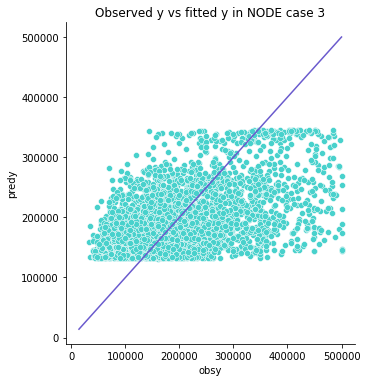

In [ ]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred3})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 3");

#### case 4

In [ ]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 64, num_layers=8, tree_dim=6, depth=4, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, ir_min=np.min(train_y), ir_max=np.max(train_y)),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0726-8'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history4, mse_history4 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0726-8


In [ ]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=300)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history2.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history2.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

49it [01:03,  1.33s/it]

Saved logs/California 0726-8\checkpoint_temp_50.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


50it [01:07,  2.11s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_50.pth
iteration:50 loss:9461798912.0 mse:9387579268.330307


99it [02:14,  1.35s/it]

Saved logs/California 0726-8\checkpoint_temp_100.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


100it [02:18,  2.13s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_100.pth
iteration:100 loss:9339435008.0 mse:9249235064.618965


149it [03:24,  1.29s/it]

Saved logs/California 0726-8\checkpoint_temp_150.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


150it [03:28,  2.17s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_150.pth
iteration:150 loss:9071705088.0 mse:9036205837.255615


199it [04:38,  1.59s/it]

Saved logs/California 0726-8\checkpoint_temp_200.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


200it [04:42,  2.38s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_200.pth
iteration:200 loss:8450834944.0 mse:8797172629.019005


249it [05:48,  1.23s/it]

Saved logs/California 0726-8\checkpoint_temp_250.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


250it [05:53,  2.16s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_250.pth
iteration:250 loss:8716312576.0 mse:8611273251.573296


299it [07:00,  1.18s/it]

Saved logs/California 0726-8\checkpoint_temp_300.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


300it [07:04,  2.10s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_300.pth
iteration:300 loss:8141605376.0 mse:8270292974.807916


349it [08:12,  1.33s/it]

Saved logs/California 0726-8\checkpoint_temp_350.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


350it [08:16,  2.17s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_350.pth
iteration:350 loss:9117688832.0 mse:8144549610.805066


399it [09:23,  1.34s/it]

Saved logs/California 0726-8\checkpoint_temp_400.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


400it [09:28,  2.26s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_400.pth
iteration:400 loss:7536878592.0 mse:8028322377.63813


449it [10:35,  1.39s/it]

Saved logs/California 0726-8\checkpoint_temp_450.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


450it [10:39,  2.26s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_450.pth
iteration:450 loss:7204844032.0 mse:7956172645.775049


499it [11:46,  1.32s/it]

Saved logs/California 0726-8\checkpoint_temp_500.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


500it [11:50,  2.14s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_500.pth
iteration:500 loss:8060699648.0 mse:7843377114.788349


549it [12:55,  1.26s/it]

Saved logs/California 0726-8\checkpoint_temp_550.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


550it [12:59,  2.10s/it]

Loaded logs/California 0726-8\checkpoint_temp_550.pth
iteration:550 loss:7685313024.0 mse:7950865606.982359


599it [14:06,  1.28s/it]

Saved logs/California 0726-8\checkpoint_temp_600.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


600it [14:10,  2.13s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_600.pth
iteration:600 loss:7726315520.0 mse:7736664288.257158


649it [15:20,  1.38s/it]

Saved logs/California 0726-8\checkpoint_temp_650.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


650it [15:24,  2.01s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_650.pth
iteration:650 loss:7740296192.0 mse:7667475056.763193


699it [16:32,  1.47s/it]

Saved logs/California 0726-8\checkpoint_temp_700.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


700it [16:36,  2.30s/it]

Loaded logs/California 0726-8\checkpoint_temp_700.pth
iteration:700 loss:7427244544.0 mse:7668210424.0348015


749it [17:44,  1.33s/it]

Saved logs/California 0726-8\checkpoint_temp_750.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


750it [17:48,  2.16s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_750.pth
iteration:750 loss:7219463168.0 mse:7431868143.315572


799it [18:54,  1.34s/it]

Saved logs/California 0726-8\checkpoint_temp_800.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


800it [18:58,  2.18s/it]

Saved logs/California 0726-8\checkpoint_best_mse.pth
Loaded logs/California 0726-8\checkpoint_temp_800.pth
iteration:800 loss:7668807680.0 mse:7241022506.5810585


849it [20:05,  1.39s/it]

Saved logs/California 0726-8\checkpoint_temp_850.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


850it [20:09,  2.26s/it]

Loaded logs/California 0726-8\checkpoint_temp_850.pth
iteration:850 loss:8286018560.0 mse:7241119680.498178


899it [21:19,  1.32s/it]

Saved logs/California 0726-8\checkpoint_temp_900.pth
Loaded logs/California 0726-8\checkpoint_avg.pth


900it [21:24,  2.26s/it]

Loaded logs/California 0726-8\checkpoint_temp_900.pth
iteration:900 loss:6803623424.0 mse:7272718110.573293


900it [21:25,  1.43s/it]

BREAK. There is no improvment for 100 steps
Best step:  800
Best Val MSE: 7241022506.58106


In [ ]:
y_pred4 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred4))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred4)))

RMSE: 85598.27321168037
Pseudo R^2: 0.24967932446408803


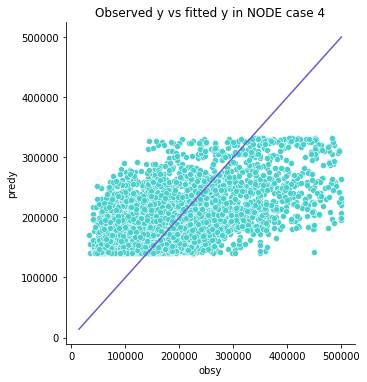

In [ ]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred4})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 4");

#### case5: initialization 범위 수정

In [ ]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 1024, num_layers=1, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, 
                   ir_min=np.min(train_y)-200000, ir_max=np.max(train_y)+200000),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0727-1'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0727-1


In [ ]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=512, 
                                                shuffle=True, epochs=200)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

0it [00:00, ?it/s]..\lib\odst.py:119: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
C:\Users\YJ-HWANG\anaconda3\lib\site-packages\qhoptim\pyt\qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)
49it [01:44,  2.06s/it]

Saved logs/California 0727-1\checkpoint_temp_50.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


50it [01:48,  2.66s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_50.pth
iteration:50 loss:12972073984.0 mse:13293672756.464678


99it [03:54,  3.15s/it]

Saved logs/California 0727-1\checkpoint_temp_100.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


100it [03:58,  3.51s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_100.pth
iteration:100 loss:12729859072.0 mse:13156504931.068926


149it [06:41,  3.54s/it]

Saved logs/California 0727-1\checkpoint_temp_150.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


150it [06:46,  3.74s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_150.pth
iteration:150 loss:12296077312.0 mse:13021563415.819118


199it [09:41,  3.66s/it]

Saved logs/California 0727-1\checkpoint_temp_200.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


200it [09:45,  3.99s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_200.pth
iteration:200 loss:12963540992.0 mse:12887698030.268238


249it [12:39,  3.54s/it]

Saved logs/California 0727-1\checkpoint_temp_250.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


250it [12:43,  3.80s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_250.pth
iteration:250 loss:12220796928.0 mse:12754825449.655598


299it [15:39,  3.78s/it]

Saved logs/California 0727-1\checkpoint_temp_300.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


300it [15:43,  3.98s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_300.pth
iteration:300 loss:12712573952.0 mse:12488323274.99288


349it [18:35,  3.48s/it]

Saved logs/California 0727-1\checkpoint_temp_350.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


350it [18:39,  3.78s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_350.pth
iteration:350 loss:12384418816.0 mse:12224923709.656609


399it [21:32,  3.67s/it]

Saved logs/California 0727-1\checkpoint_temp_400.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


400it [21:36,  3.86s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_400.pth
iteration:400 loss:9443152896.0 mse:11968780407.851162


449it [24:29,  3.53s/it]

Saved logs/California 0727-1\checkpoint_temp_450.pth
Loaded logs/California 0727-1\checkpoint_avg.pth


450it [24:33,  3.83s/it]

Saved logs/California 0727-1\checkpoint_best_mse.pth
Loaded logs/California 0727-1\checkpoint_temp_450.pth
iteration:450 loss:10815291392.0 mse:11725024613.893478


462it [25:22,  3.30s/it]


KeyboardInterrupt: 

In [ ]:
y_pred5 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred5))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred5)))

RMSE: 88103.31956372989
Pseudo R^2: 0.2051202179892232


### server 이용

#### 원래 깃허브 코드대로 train y를 (y-mean)/std 로 정규화해서 예측한 후 예측값에 다시 std*y+mean 계산

In [10]:
mu, std = train_y.mean(), train_y.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
train_y1, valid_y1, test_y1 = map(normalize, [train_y, valid_y, test_y])

print("mean = %.5f, std = %.5f" % (mu, std))

mean = 192398.50738, std = 97339.89818


In [22]:
in_features = train_x.shape[1]

model = nn.Sequential(
    libs.DenseBlock(in_features, 64, num_layers=8, tree_dim=3, depth=4, flatten_output=False,
                   choice_function=libs.entmax15, bin_function=libs.entmoid15, 
                   ir = 'normal'),
    libs.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California 0728'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = libs.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history2, mse_history2 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

/content/drive/MyDrive/Lab/node-master/libs/odst.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)


experiment: California 0728


NameError: name 'train_x' is not defined

In [23]:
for batch in tqdm(libs.iterate_minibatches(train_x, train_y1, batch_size=1024, 
                                                shuffle=True, epochs=300)):
    metrics = trainer.train_on_batch(*batch, device=device)
    loss_history2.append(metrics['loss'])
    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y1, device=device, batch_size=1024)
        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history2.append(mse)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints() 
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/qhoptim/pyt/qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)
47it [00:07, 24.19it/s]

Saved logs/California 0728/checkpoint_temp_50.pth
Loaded logs/California 0728/checkpoint_avg.pth


53it [00:08, 15.37it/s]

Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_50.pth
iteration:50 loss:0.8713616132736206 mse:0.8507789373397827


98it [00:09, 25.04it/s]

Saved logs/California 0728/checkpoint_temp_100.pth


101it [00:10, 11.87it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_100.pth
iteration:100 loss:0.7604697346687317 mse:0.7823851704597473


149it [00:12, 24.96it/s]

Saved logs/California 0728/checkpoint_temp_150.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_150.pth
iteration:150 loss:0.6846949458122253 mse:0.7363343834877014


197it [00:14, 24.98it/s]

Saved logs/California 0728/checkpoint_temp_200.pth


200it [00:15, 10.11it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_200.pth
iteration:200 loss:0.6221730709075928 mse:0.701119065284729


248it [00:17, 25.07it/s]

Saved logs/California 0728/checkpoint_temp_250.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_250.pth
iteration:250 loss:0.5508671402931213 mse:0.6716445684432983


299it [00:20, 25.23it/s]

Saved logs/California 0728/checkpoint_temp_300.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_300.pth
iteration:300 loss:0.5861677527427673 mse:0.6184451580047607


347it [00:22, 24.26it/s]

Saved logs/California 0728/checkpoint_temp_350.pth


350it [00:23, 10.34it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_350.pth
iteration:350 loss:0.500700831413269 mse:0.5777221918106079


398it [00:25, 22.77it/s]

Saved logs/California 0728/checkpoint_temp_400.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_400.pth
iteration:400 loss:0.5194201469421387 mse:0.5436592698097229


449it [00:27, 23.74it/s]

Saved logs/California 0728/checkpoint_temp_450.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_450.pth
iteration:450 loss:0.49457287788391113 mse:0.5154647827148438


497it [00:30, 24.14it/s]

Saved logs/California 0728/checkpoint_temp_500.pth


500it [00:31, 10.14it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_500.pth
iteration:500 loss:0.4517703056335449 mse:0.4939100444316864


548it [00:33, 25.10it/s]

Saved logs/California 0728/checkpoint_temp_550.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_550.pth
iteration:550 loss:0.4609546363353729 mse:0.4737063944339752


599it [00:35, 24.74it/s]

Saved logs/California 0728/checkpoint_temp_600.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_600.pth
iteration:600 loss:0.42822760343551636 mse:0.4561929702758789


647it [00:38, 24.73it/s]

Saved logs/California 0728/checkpoint_temp_650.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth


653it [00:39, 11.85it/s]

Loaded logs/California 0728/checkpoint_temp_650.pth
iteration:650 loss:0.31874409317970276 mse:0.4390064477920532


698it [00:40, 23.81it/s]

Saved logs/California 0728/checkpoint_temp_700.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_700.pth
iteration:700 loss:0.3804090619087219 mse:0.42364829778671265


749it [00:43, 24.59it/s]

Saved logs/California 0728/checkpoint_temp_750.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_750.pth
iteration:750 loss:0.362246036529541 mse:0.41040629148483276


797it [00:46, 24.61it/s]

Saved logs/California 0728/checkpoint_temp_800.pth


800it [00:46, 10.23it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_800.pth
iteration:800 loss:0.3743479251861572 mse:0.3991119861602783


848it [00:48, 25.08it/s]

Saved logs/California 0728/checkpoint_temp_850.pth


851it [00:49, 10.37it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_850.pth
iteration:850 loss:0.38635945320129395 mse:0.38804927468299866


899it [00:51, 24.89it/s]

Saved logs/California 0728/checkpoint_temp_900.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_900.pth
iteration:900 loss:0.33404281735420227 mse:0.37813958525657654


947it [00:53, 24.50it/s]

Saved logs/California 0728/checkpoint_temp_950.pth


950it [00:54,  9.84it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_950.pth
iteration:950 loss:0.32334989309310913 mse:0.37069979310035706


999it [00:57, 16.00it/s]

Saved logs/California 0728/checkpoint_temp_1000.pth


1001it [00:57,  6.60it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1000.pth
iteration:1000 loss:0.33111339807510376 mse:0.3635905385017395


1049it [00:59, 23.21it/s]

Saved logs/California 0728/checkpoint_temp_1050.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1050.pth
iteration:1050 loss:0.29340654611587524 mse:0.3557244837284088


1097it [01:02, 25.01it/s]

Saved logs/California 0728/checkpoint_temp_1100.pth


1100it [01:03, 10.42it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1100.pth
iteration:1100 loss:0.30955466628074646 mse:0.34912022948265076


1148it [01:04, 24.04it/s]

Saved logs/California 0728/checkpoint_temp_1150.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1150.pth
iteration:1150 loss:0.3395191431045532 mse:0.34304186701774597


1198it [01:08, 23.40it/s]

Saved logs/California 0728/checkpoint_temp_1200.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth


1204it [01:09, 11.52it/s]

Loaded logs/California 0728/checkpoint_temp_1200.pth
iteration:1200 loss:0.3045268654823303 mse:0.33792683482170105


1249it [01:11, 25.31it/s]

Saved logs/California 0728/checkpoint_temp_1250.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1250.pth
iteration:1250 loss:0.2643459141254425 mse:0.3338370621204376


1297it [01:14, 24.52it/s]

Saved logs/California 0728/checkpoint_temp_1300.pth


1300it [01:14,  9.70it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1300.pth
iteration:1300 loss:0.27327680587768555 mse:0.329677939414978


1347it [01:16, 24.24it/s]

Saved logs/California 0728/checkpoint_temp_1350.pth


1350it [01:17,  8.80it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1350.pth
iteration:1350 loss:0.3092780113220215 mse:0.3257860243320465


1398it [01:19, 24.53it/s]

Saved logs/California 0728/checkpoint_temp_1400.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1400.pth
iteration:1400 loss:0.37280240654945374 mse:0.32237887382507324


1449it [01:22, 24.60it/s]

Saved logs/California 0728/checkpoint_temp_1450.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1450.pth
iteration:1450 loss:0.2705365717411041 mse:0.31836751103401184


1497it [01:24, 25.11it/s]

Saved logs/California 0728/checkpoint_temp_1500.pth


1500it [01:25,  7.94it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1500.pth
iteration:1500 loss:0.28043830394744873 mse:0.3146609365940094


1548it [01:27, 22.59it/s]

Saved logs/California 0728/checkpoint_temp_1550.pth


1551it [01:28, 10.18it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1550.pth
iteration:1550 loss:0.3114809989929199 mse:0.311702162027359


1599it [01:30, 25.57it/s]

Saved logs/California 0728/checkpoint_temp_1600.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1600.pth
iteration:1600 loss:0.2654046416282654 mse:0.3094080090522766


1647it [01:32, 24.38it/s]

Saved logs/California 0728/checkpoint_temp_1650.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth


1653it [01:33, 11.77it/s]

Loaded logs/California 0728/checkpoint_temp_1650.pth
iteration:1650 loss:0.28494060039520264 mse:0.30655932426452637


1698it [01:35, 21.43it/s]

Saved logs/California 0728/checkpoint_temp_1700.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1700.pth
iteration:1700 loss:0.29858124256134033 mse:0.30422475934028625


1749it [01:38, 24.64it/s]

Saved logs/California 0728/checkpoint_temp_1750.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1750.pth
iteration:1750 loss:0.26477503776550293 mse:0.30252140760421753


1797it [01:41, 25.08it/s]

Saved logs/California 0728/checkpoint_temp_1800.pth


1800it [01:41, 10.33it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1800.pth
iteration:1800 loss:0.25893446803092957 mse:0.2998792827129364


1848it [01:43, 25.44it/s]

Saved logs/California 0728/checkpoint_temp_1850.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1850.pth
iteration:1850 loss:0.24483005702495575 mse:0.29622167348861694


1899it [01:46, 25.77it/s]

Saved logs/California 0728/checkpoint_temp_1900.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1900.pth
iteration:1900 loss:0.24843798577785492 mse:0.29398465156555176


1947it [01:48, 24.29it/s]

Saved logs/California 0728/checkpoint_temp_1950.pth


1950it [01:49, 10.55it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_1950.pth
iteration:1950 loss:0.22111672163009644 mse:0.2923928201198578


1998it [01:51, 24.12it/s]

Saved logs/California 0728/checkpoint_temp_2000.pth


2001it [01:52, 10.34it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2000.pth
iteration:2000 loss:0.23305843770503998 mse:0.2920154929161072


2049it [01:53, 24.73it/s]

Saved logs/California 0728/checkpoint_temp_2050.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2050.pth


2055it [01:55,  9.34it/s]

iteration:2050 loss:0.261200487613678 mse:0.2903519570827484


2097it [01:56, 25.00it/s]

Saved logs/California 0728/checkpoint_temp_2100.pth


2100it [01:57, 10.52it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2100.pth
iteration:2100 loss:0.277971476316452 mse:0.29004618525505066


2148it [01:59, 25.01it/s]

Saved logs/California 0728/checkpoint_temp_2150.pth


2151it [02:00,  9.83it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2150.pth
iteration:2150 loss:0.24200505018234253 mse:0.288245290517807


2199it [02:02, 25.20it/s]

Saved logs/California 0728/checkpoint_temp_2200.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2200.pth
iteration:2200 loss:0.2901870906352997 mse:0.2860132157802582


2247it [02:04, 24.28it/s]

Saved logs/California 0728/checkpoint_temp_2250.pth


2250it [02:05,  9.58it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2250.pth
iteration:2250 loss:0.2357991486787796 mse:0.28533491492271423


2298it [02:07, 24.45it/s]

Saved logs/California 0728/checkpoint_temp_2300.pth


2301it [02:08,  9.97it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2300.pth
iteration:2300 loss:0.21500849723815918 mse:0.283780574798584


2349it [02:10, 24.18it/s]

Saved logs/California 0728/checkpoint_temp_2350.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2350.pth
iteration:2350 loss:0.251562237739563 mse:0.2826915681362152


2397it [02:12, 24.75it/s]

Saved logs/California 0728/checkpoint_temp_2400.pth


2400it [02:13, 10.29it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2400.pth
iteration:2400 loss:0.22590303421020508 mse:0.2826445698738098


2448it [02:15, 23.93it/s]

Saved logs/California 0728/checkpoint_temp_2450.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2450.pth
iteration:2450 loss:0.2673371732234955 mse:0.2810296416282654


2499it [02:17, 24.49it/s]

Saved logs/California 0728/checkpoint_temp_2500.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2500.pth
iteration:2500 loss:0.23606523871421814 mse:0.280606210231781


2547it [02:20, 24.22it/s]

Saved logs/California 0728/checkpoint_temp_2550.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2550.pth


2553it [02:21,  9.17it/s]

iteration:2550 loss:0.2407039999961853 mse:0.2803957760334015


2598it [02:23, 24.64it/s]

Saved logs/California 0728/checkpoint_temp_2600.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2600.pth
iteration:2600 loss:0.18192361295223236 mse:0.27953678369522095


2649it [02:26, 24.37it/s]

Saved logs/California 0728/checkpoint_temp_2650.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2650.pth
iteration:2650 loss:0.22034364938735962 mse:0.2790318727493286


2697it [02:28, 24.87it/s]

Saved logs/California 0728/checkpoint_temp_2700.pth


2700it [02:29, 10.29it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2700.pth
iteration:2700 loss:0.21357592940330505 mse:0.27847525477409363


2748it [02:31, 24.45it/s]

Saved logs/California 0728/checkpoint_temp_2750.pth
Loaded logs/California 0728/checkpoint_avg.pth
Saved logs/California 0728/checkpoint_best_mse.pth
Loaded logs/California 0728/checkpoint_temp_2750.pth
iteration:2750 loss:0.23563088476657867 mse:0.27817708253860474


2799it [02:33, 24.99it/s]

Saved logs/California 0728/checkpoint_temp_2800.pth


2802it [02:34, 11.21it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Loaded logs/California 0728/checkpoint_temp_2800.pth
iteration:2800 loss:0.23812687397003174 mse:0.2788424789905548


2847it [02:37, 16.74it/s]

Saved logs/California 0728/checkpoint_temp_2850.pth


2850it [02:37, 18.06it/s]

Loaded logs/California 0728/checkpoint_avg.pth
Loaded logs/California 0728/checkpoint_temp_2850.pth
iteration:2850 loss:0.20685356855392456 mse:0.2798539400100708
BREAK. There is no improvment for 100 steps
Best step:  2750
Best Val MSE: 0.27818


In [24]:
y_pred = trainer.get_prediction(test_x, test_y1, device=device)
y_pred = y_pred*std + mu
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred)))

RMSE: 53429.958406289166
Pseudo R^2: 0.7076611200403509


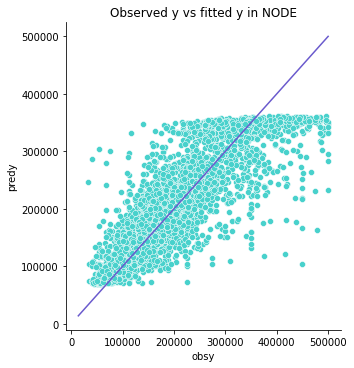

<Figure size 432x288 with 0 Axes>

In [25]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE")
plt.show()
plt.savefig('pred_node_0728.png')

RMSE  55122.8387, R^2 0.6888, 실행시간 3분 58초